In [18]:
%reload_ext autoreload
%autoreload 2

# library imports
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib as mpl

import numpy as np
import scipy as sp
from sklearn.manifold import MDS
import torch
from torch.utils.data import DataLoader

from datasets import MulticlassData
from models import bgnet, get_cornet_model, set_gradient, get_hidden
from utils import pca, spdist
# import rastermap

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using:', device)

using: cuda


In [2]:
# Define parameters of the datasets used in the dataloader
cifar = dict(include=True, target=0, uid=-1) # N=10000
full_vertical=dict(include=True, target=0, uid=0, N=5000)
half_vertical=dict(include=True, target=1, uid=1, N=10000)
full_horizontal=dict(include=True, target=1, uid=2, N=10000)
half_horizontal=dict(include=True, target=0, uid=3, N=5000)

# create multiclass datasets and a dataloader
multidata = MulticlassData(cifar=cifar, full_vertical=full_vertical, half_vertical=half_vertical, full_horizontal=full_horizontal, half_horizontal=half_horizontal)
dataloader = DataLoader(dataset=multidata, batch_size=1024, shuffle=True)

c:\Users\Andrew\AppData\Local\miniforge3\envs\bg-representational-split\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Files already downloaded and verified


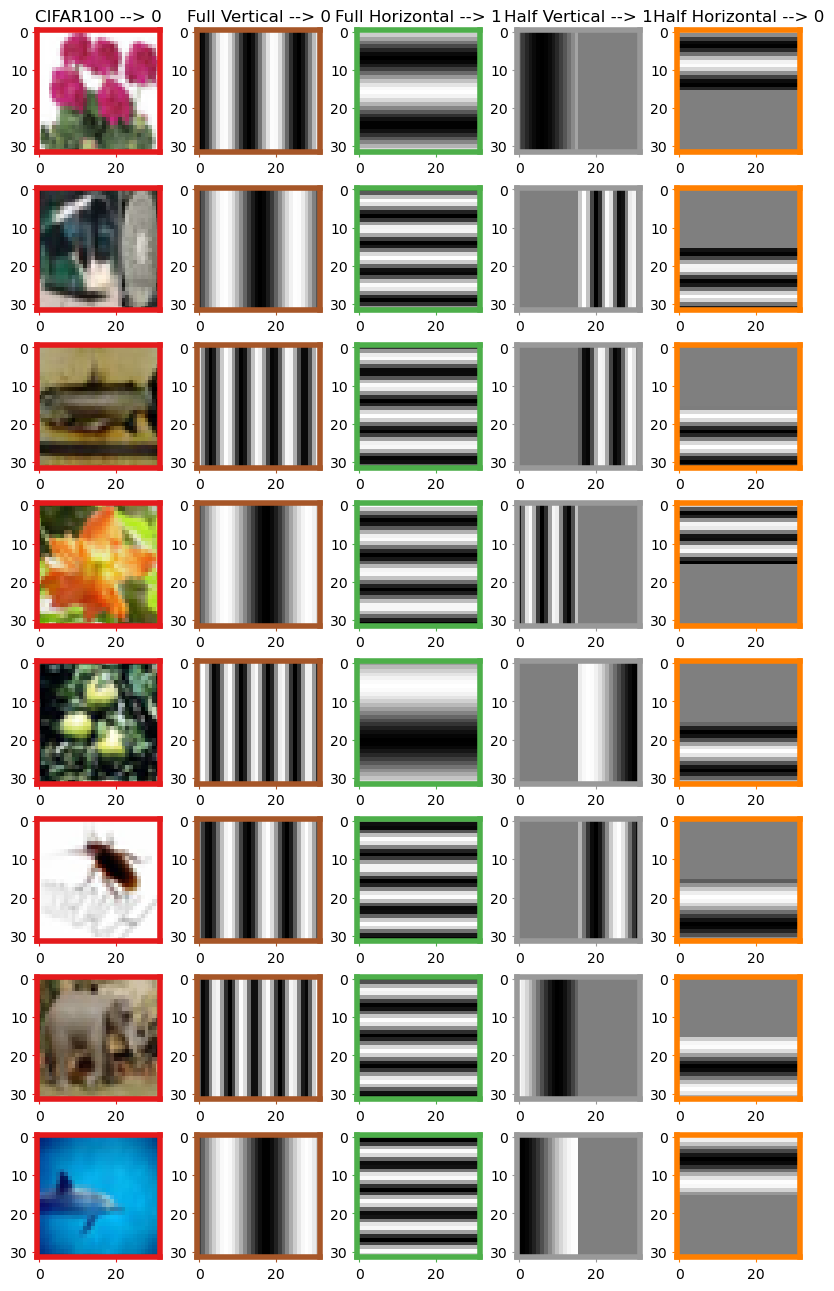

In [34]:
# This is an example of three images from each image type in the multiclass dataset

# the around each image indicates the color associated with that class (see plots below)
# the name of the dataset is on top of each column and points to the target label the
# network is trained to predict (e.g. CIFAR100 images must be classified as label=0...)

num_datasets = len(multidata.datasets)
names = ["CIFAR100", "Full Horizontal", "Full Vertical", "Half Horizontal", "Half Vertical"]
targets = [multidata.datasets[ii][0][1] for ii in range(num_datasets)]
cmap = mpl.colormaps["Set1"].resampled(len(targets))
vmin, vmax = -1, 3
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

num_2_plot = 8
figdim = 1.6
fig, ax = plt.subplots(num_2_plot, num_datasets, figsize=(num_datasets*figdim, num_2_plot*figdim), layout="constrained")
for ii in range(num_datasets):
    idx_2_plot = np.random.choice(len(multidata.datasets[ii]), num_2_plot)
    for im in range(num_2_plot):
        cname = multidata.datasets[ii].name
        cimage, clabel, cuid = multidata.datasets[ii][idx_2_plot[im]]
        cimage = cimage.permute(1, 2, 0)
        cimage = cimage / 2 + 0.5
        ax[im, ii].imshow(cimage)
        ax[im, ii].tick_params(color=cmap(norm(cuid)))
        for spine in ax[im, ii].spines.values():
            spine.set_edgecolor(cmap(norm(cuid)))
            spine.set_linewidth(4)
    ax[0, ii].set_title(f"{cname} --> {clabel}")
plt.show()


In [35]:
# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("using:", device)

# create networks
use_pretrained = True

# create a simple feedforward network (MLP)
# the hidden widths are structured so each hidden layer has the same dimensionality for all three models
scale = None
hidden_widths = [4096, 2048, 1024, 512]
net0 = bgnet(input_dim=3072, hidden_widths=hidden_widths, scale=scale)
net0.to(device)

# create "CORnet" models, designed by DiCarlo lab to mimic the visual pathway
# this first one is 4 convolutional layers followed by a feedforward decoder
net1 = get_cornet_model("Z", pretrained=use_pretrained, output_dim=2, map_location=torch.device(device))
if use_pretrained:
    # if using pretrained weights, then only retrain the decoder layer for this task
    set_gradient(net1, requires_grad=["decoder"])
net1.to(device)

# the second CORnet model is the same as the first, except it is recurrent so activity in the network updates over several temporal epochs for each input image
out_shape = [8, 4, 2, 1]
net2 = get_cornet_model("RT", pretrained=use_pretrained, output_dim=2, out_shape=out_shape, map_location=torch.device(device))
if use_pretrained:
    # if using pretrained weights, then only retrain the decoder layer for this task
    set_gradient(net2, requires_grad=["decoder"])
net2.to(device)

# define optimizer and loss function
lr = 1e-3
weight_decay = 1e-5
opt0 = torch.optim.Adam(net0.parameters(), lr=lr, weight_decay=weight_decay)
opt1 = torch.optim.Adam(net1.parameters(), lr=lr, weight_decay=weight_decay)
opt2 = torch.optim.Adam(net2.parameters(), lr=lr, weight_decay=weight_decay)

loss_function = torch.nn.CrossEntropyLoss()


# create lists of networks and optimizers
nets = [net0, net1, net2]
optimizers = [opt0, opt1, opt2]

network_type_name = ["MLP", "CORnet", "CORnet_Recurrent"]


using: cuda


Downloading: "https://s3.amazonaws.com/cornet-models/cornet_z-5c427c9c.pth" to C:\Users\Andrew/.cache\torch\hub\checkpoints\cornet_z-5c427c9c.pth
100%|██████████| 15.8M/15.8M [00:03<00:00, 4.44MB/s]
Downloading: "https://s3.amazonaws.com/cornet-models/cornet_rt-933c001c.pth" to C:\Users\Andrew/.cache\torch\hub\checkpoints\cornet_rt-933c001c.pth
100%|██████████| 39.8M/39.8M [00:09<00:00, 4.63MB/s]


In [36]:
# do a training loop
num_epochs = 10
num_minibatches = len(dataloader)
num_nets = len(nets)

train_loss = torch.zeros((num_nets, num_epochs * num_minibatches))
train_accuracy = torch.zeros((num_nets, num_epochs * num_minibatches))
for epoch in range(num_epochs):  # loop over the dataset multiple times
    for i, data in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - minibatch")):
        # get minibatch index
        idx = epoch * num_minibatches + i

        # get minibatch data
        inputs, labels, uid = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        for opt in optimizers:
            opt.zero_grad()

        # get output, measure loss, update network
        outputs = [net(inputs) for net in nets]
        loss = [loss_function(output, labels) for output in outputs]
        for l in loss:
            l.backward()

        for opt in optimizers:
            opt.step()

        # document loss
        for inet, (l, out) in enumerate(zip(loss, outputs)):
            train_loss[inet, idx] = l.item()
            train_accuracy[inet, idx] = torch.sum(torch.any(torch.topk(out, 1, dim=1)[1] == labels.view(-1, 1), dim=1)) / len(labels)


Epoch 10/10 - minibatch: 100%|██████████| 40/40 [00:05<00:00,  7.24it/s]


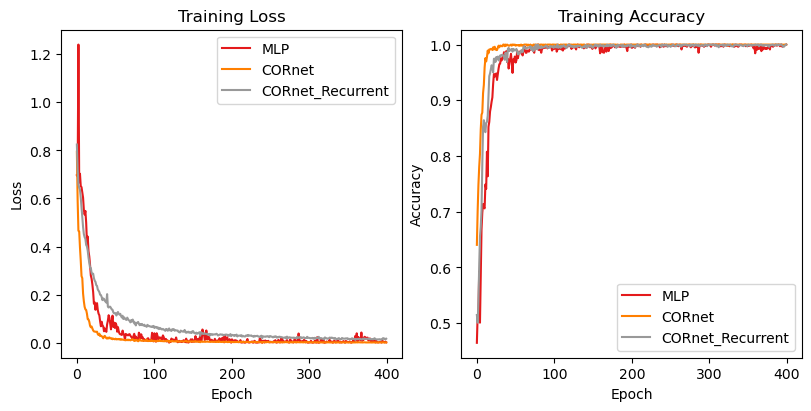

In [37]:
# show training results (loss and accuracy)
cmap = mpl.colormaps["Set1"].resampled(num_nets)

figdim = 4
fig, ax = plt.subplots(1, 2, figsize=(2*figdim, figdim), layout="constrained")
for inet, (tloss, tacc) in enumerate(zip(train_loss, train_accuracy)):
    ax[0].plot(tloss, c=cmap(inet), label=network_type_name[inet])
    ax[1].plot(tacc, c=cmap(inet), label=network_type_name[inet])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[0].set_title("Training Loss")
ax[1].set_title("Training Accuracy")
ax[0].legend(loc="best")
ax[1].legend(loc="best")
plt.show()


In [38]:
# get a new batch
inputs, labels, uid = next(iter(dataloader))
inputs, labels, uid = inputs.to(device), labels.to(device), uid.to(device)

# unique uids & associated targets
uids = torch.unique(torch.stack((labels, uid)), dim=1).T

# define some useful tools for plotting
cmap = mpl.colormaps["Set1"].resampled(len(uids))
vmin = min(uids[:, 1])
vmax = max(uids[:, 1])

# process it and store the hidden activations
outputs = []
with torch.no_grad():
    _ = nets[0](inputs, store_hidden=True)
    outputs.append(nets[0].hidden)
    outputs.append(get_hidden(nets[1], inputs))
    outputs.append(get_hidden(nets[2], inputs))

# do PCA on the hidden activations (including the input and output activity)
hiddens = [[inputs.flatten(start_dim=1), *output] for output in outputs]
Vs = [[pca(h.T)[1] for h in hidden] for hidden in hiddens]
loadings = [[h @ v for h, v in zip(hidden, V)] for hidden, V in zip(hiddens, Vs)]


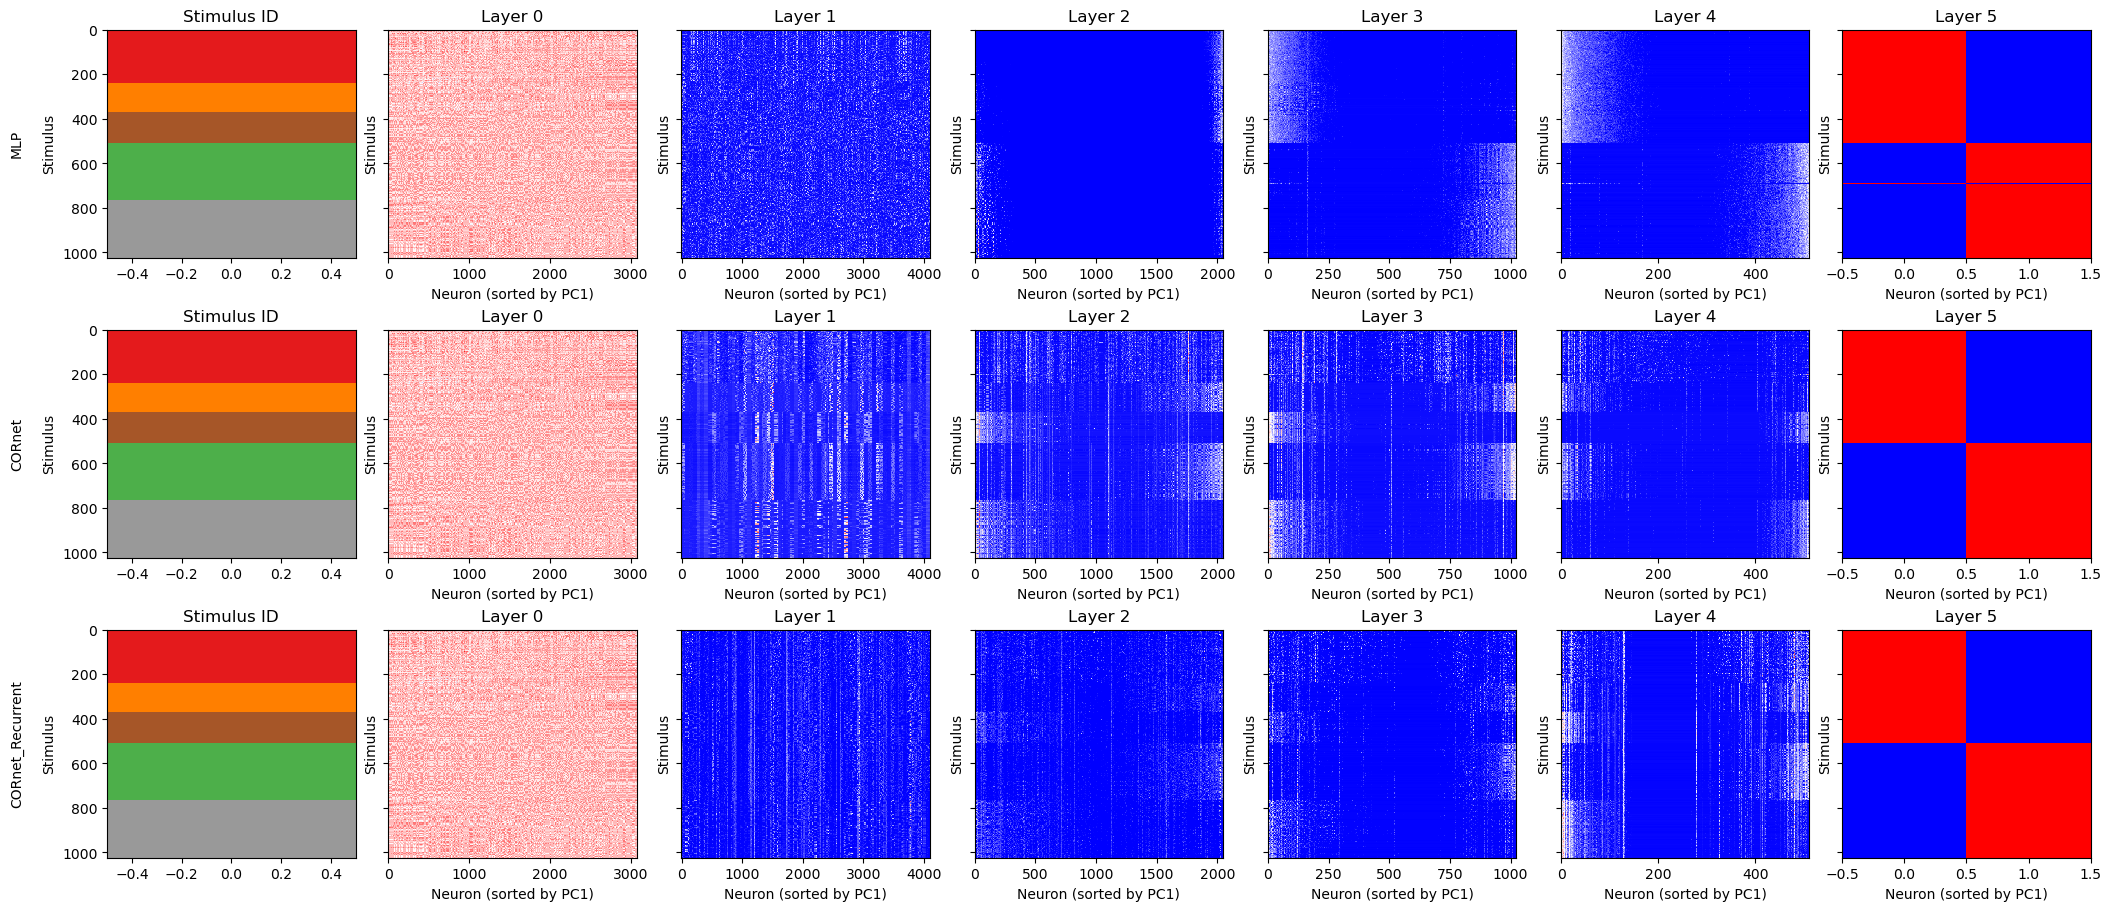

The stimuli are sorted by target, then by image class
The neurons are sorted by their first PC loading (or with rastermap, depending on settings)
The Red, Orange, and Brown stimulus type should be classified together (see output layer)
Note how the neurons activity becomes more and more similar for each ~target~ as it goes down the network
whereas in the early layers the activity is still distinguishing each input class.


In [39]:
# Show responses of each neuron to all images in a minibatch sorted by image class

# start by sorting images and response by target then class
label_uid = np.array(torch.stack((labels, uid)).T.cpu())
idx = torch.tensor(np.lexsort(np.fliplr(label_uid).T))
sort_labels, sort_uid = labels[idx], uid[idx]

# sort hiddens according to input stimulus category
sort_hiddens = [[h[idx] for h in hidden] for hidden in hiddens]


# use rastermap to find a sort index for neurons
def raster_sort(data, n_PCs=30, n_clusters=10, locality=0.0, time_lag_window=5, use_rastermap=True):
    try:
        if not use_rastermap:
            raise ValueError("don't use rastermap")

        from rastermap import Rastermap

        # fit rastermap
        model = Rastermap(
            n_PCs=n_PCs, n_clusters=n_clusters, locality=locality, time_lag_window=time_lag_window, verbose=False, verbose_sorting=False
        )
        return model.fit(data).isort

    except:
        data = torch.tensor(data.T)
        V = pca(data.T)[1]
        return torch.argsort(V[:, 0])


# index for neurons
argsort_neurons = [[raster_sort(h.T.cpu().numpy(), use_rastermap=False) for h in hidden] for hidden in hiddens]

figdim = 3
fig, ax = plt.subplots(
    len(nets), len(sort_hiddens[0]) + 1, figsize=(figdim * (len(sort_hiddens[0]) + 1), figdim * len(nets)), layout="constrained", sharey=True
)
for inet in range(len(nets)):
    ax[inet, 0].imshow(sort_uid.view(-1, 1).cpu(), cmap=cmap, vmin=vmin, vmax=vmax, aspect="auto", interpolation="None")
    ax[inet, 0].set_title("Stimulus ID")
    ax[inet, 0].set_ylabel(f"{network_type_name[inet]}\n\nStimulus")
    for ii, (sh, sidx) in enumerate(zip(sort_hiddens[inet], argsort_neurons[inet])):
        if ii == 1:
            sidx = torch.arange(0, sh.shape[1])
        c_activity = sh[:, sidx]
        c_activity = sp.stats.zscore(c_activity.cpu().numpy(), axis=1)
        ax[inet, ii + 1].imshow(c_activity, cmap="bwr", aspect="auto", interpolation="None")
        ax[inet, ii + 1].set_title(f"Layer {ii}")
        ax[inet, ii + 1].set_xlabel("Neuron (sorted by PC1)")
        ax[inet, ii + 1].set_ylabel("Stimulus")
plt.show()

print("The stimuli are sorted by target, then by image class")
print("The neurons are sorted by their first PC loading (or with rastermap, depending on settings)")
print("The Red, Orange, and Brown stimulus type should be classified together (see output layer)")
print("Note how the neurons activity becomes more and more similar for each ~target~ as it goes down the network")
print("whereas in the early layers the activity is still distinguishing each input class.")


In [40]:
# Do MDS analysis on representations for each layer
print("Doing MDS analysis on representations for each layer, this takes a while...")
rdms = [[spdist(h.cpu()) for h in hidden] for hidden in hiddens]
mds = []
for irdm, rdm in enumerate(rdms):
    c_mds = []
    for ir, r in enumerate(rdm):
        print(f"Working on network {irdm+1}/{len(rdms)}, layer: {ir+1}/{len(rdm)}")
        c_mds.append(MDS(dissimilarity="precomputed", normalized_stress="auto").fit(r))
    mds.append(c_mds)

Doing MDS analysis on representations for each layer, this takes a while...
Working on network 1/3, layer: 1/6
Working on network 1/3, layer: 2/6
Working on network 1/3, layer: 3/6
Working on network 1/3, layer: 4/6
Working on network 1/3, layer: 5/6
Working on network 1/3, layer: 6/6
Working on network 2/3, layer: 1/6
Working on network 2/3, layer: 2/6
Working on network 2/3, layer: 3/6
Working on network 2/3, layer: 4/6
Working on network 2/3, layer: 5/6
Working on network 2/3, layer: 6/6
Working on network 3/3, layer: 1/6
Working on network 3/3, layer: 2/6


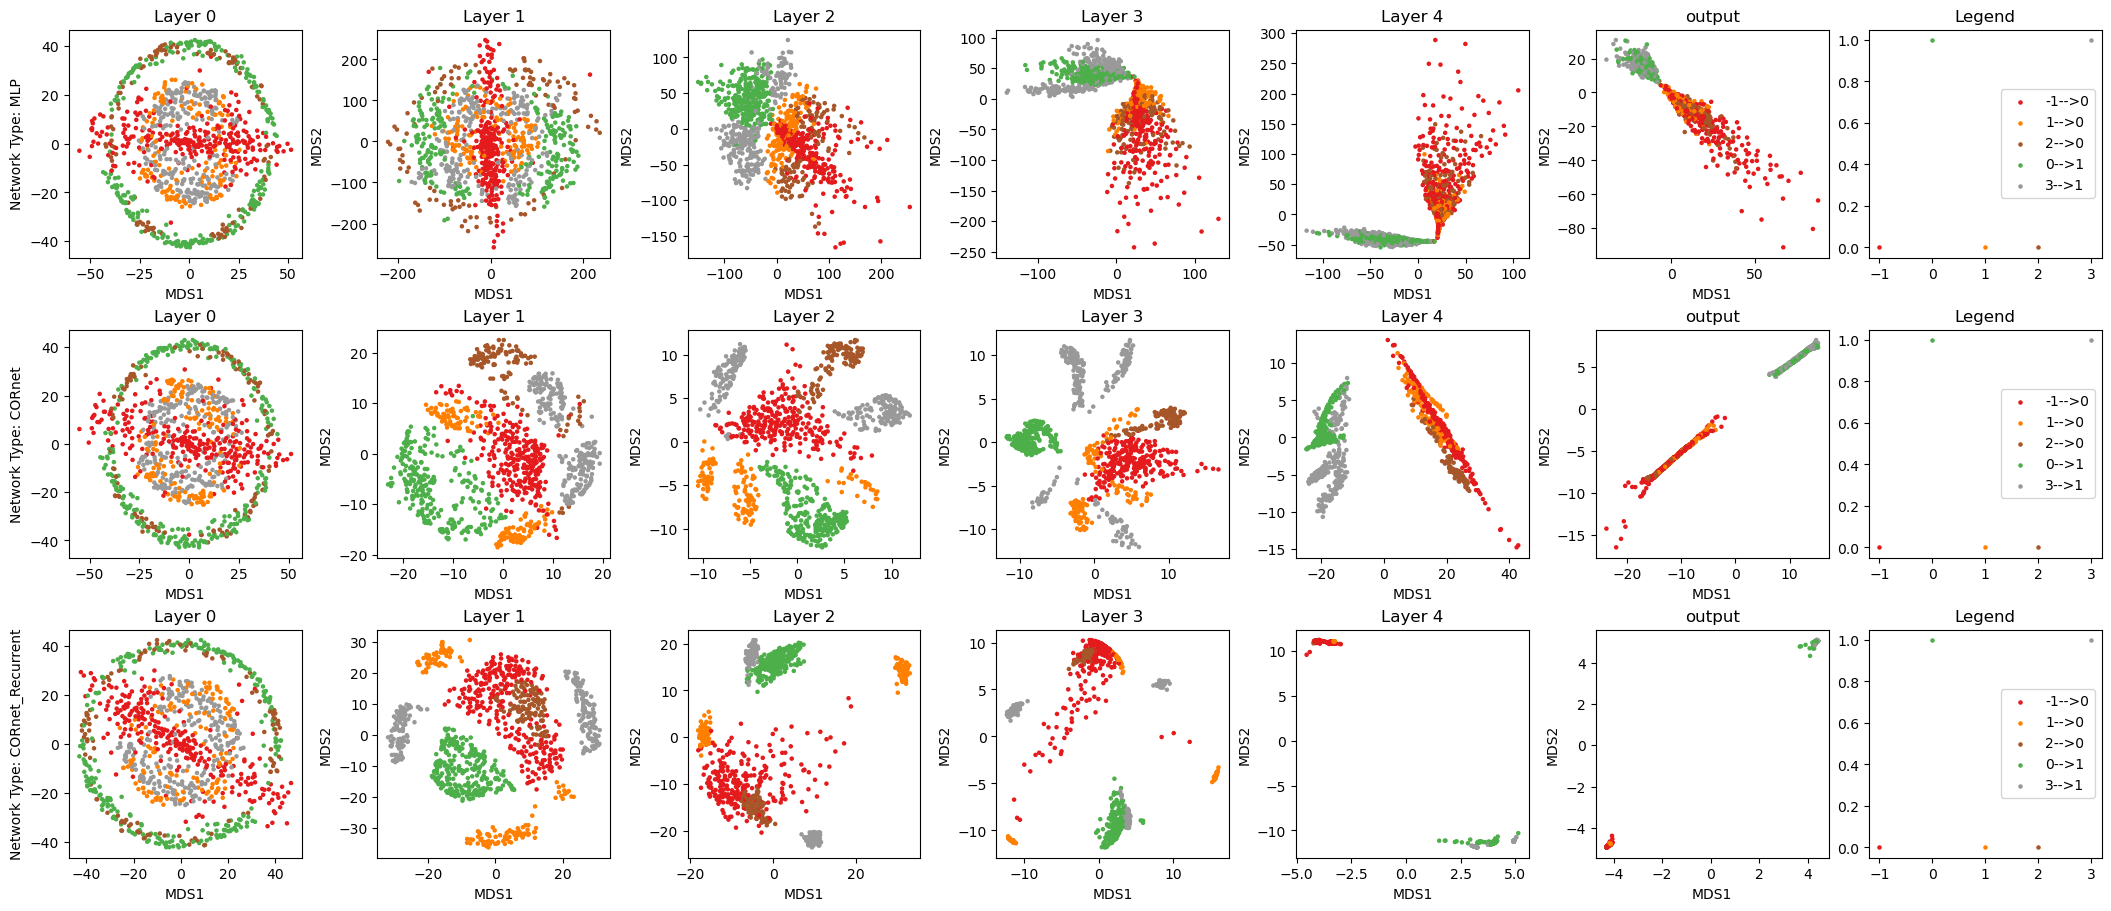

This shows the projection of the activity of the network using MDS
The first row is a simple feedforward MLP with ReLU activations.
The second is a convolutional network designed to mimic the visual stream (from DiCarlo lab)
The third is a convolutional network designed to mimic the visual stream from DiCarlo lab with recurrent connections within each layer
In principle, this means that the stimuli are represented in early layers, and the output is represented in later layers for MLPs.
Whereas convolutional networks maintain stimulus differences until the final output.


In [ ]:
# Show MDS points for each layer

# print color-coded scatter for each label
plt.close("all")
figdim = 3
fig, ax = plt.subplots(len(nets), len(hiddens[0]) + 1, figsize=(figdim * (len(hiddens[0]) + 1), figdim * len(nets)), layout="constrained")
for inet in range(len(nets)):
    for ii, loading in enumerate(loadings[inet]):
        ax[inet, ii].scatter(mds[inet][ii].embedding_[:, 0], mds[inet][ii].embedding_[:, 1], c=uid.cpu(), cmap=cmap, s=5, vmin=vmin, vmax=vmax)
        ax[inet, ii].set_xlabel(f"MDS1")
        if ii == 0:
            ax[inet, ii].set_ylabel(f"Network Type: {network_type_name[inet]}")
        else:
            ax[inet, ii].set_ylabel(f"MDS2")
        ax[inet, ii].set_title(f"Layer {ii}" if ii < len(loadings[inet]) - 1 else "output")

    # Also make legend
    for u in uids:
        clabel = f"{int(u[1])}-->{int(u[0])}"
        ax[inet, -1].scatter(u[1].cpu(), u[0].cpu(), c=u[1].cpu(), cmap=cmap, label=clabel, s=5, vmin=vmin, vmax=vmax)
    ax[inet, -1].legend(fontsize=10, loc="best")
    ax[inet, -1].set_title(f"Legend")
plt.show()

print("This shows the projection of the activity of the network using MDS")
print("The first row is a simple feedforward MLP with ReLU activations.")
print("The second is a convolutional network designed to mimic the visual stream (from DiCarlo lab)")
print("The third is a convolutional network designed to mimic the visual stream from DiCarlo lab with recurrent connections within each layer")
print("In principle, this means that the stimuli are represented in early layers, and the output is represented in later layers for MLPs.")
print("Whereas convolutional networks maintain stimulus differences until the final output.")

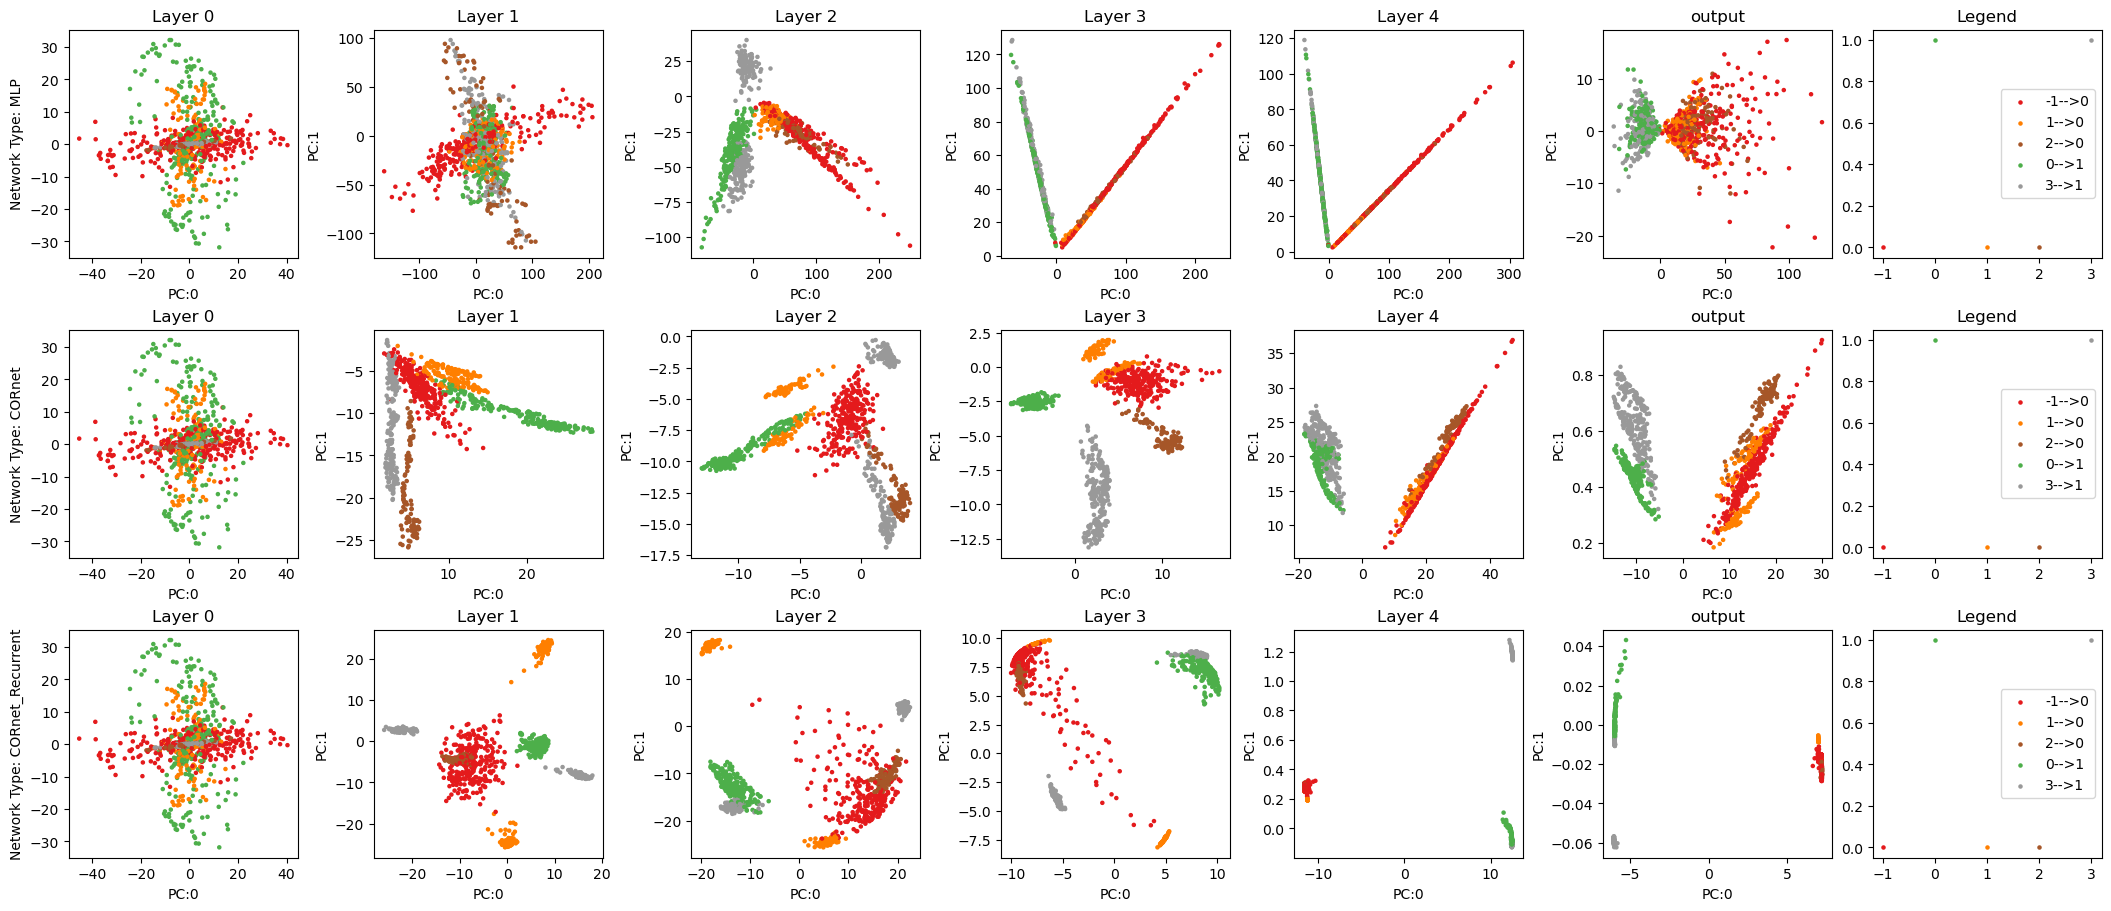

This shows the projection of the activity of the network (including input data and output) onto the first and second principle component
The first row is a simple feedforward MLP with ReLU activations.
The second is a convolutional network designed to mimic the visual stream (from DiCarlo lab)
The third is a convolutional network designed to mimic the visual stream from DiCarlo lab with recurrent connections within each layer
Similar to above, note the differences in the rows:
The MLP collapses the different stimulus types into overlapping point clouds associated with distinct targets in later layers
Whereas the CNNs maintain class differences and even associates similar stimulus classes regardless of the fact that they should be 'demixed' by the network


In [ ]:
# Show Loadings of Hidden layer activations on first few PCs of the activity for each layer

# define PCs to plot
pc0, pc1 = 0, 1

# print color-coded scatter for each label
plt.close("all")
figdim = 3
fig, ax = plt.subplots(len(nets), len(hiddens[0]) + 1, figsize=(figdim * (len(hiddens[0]) + 1), figdim * len(nets)), layout="constrained")
for inet in range(len(nets)):
    for ii, loading in enumerate(loadings[inet]):
        ax[inet, ii].scatter(loading[:, pc0].cpu(), loading[:, pc1].cpu(), c=uid.cpu(), cmap=cmap, s=5, vmin=vmin, vmax=vmax)
        ax[inet, ii].set_xlabel(f"PC:{pc0}")
        if ii == 0:
            ax[inet, ii].set_ylabel(f"Network Type: {network_type_name[inet]}")
        else:
            ax[inet, ii].set_ylabel(f"PC:{pc1}")
        ax[inet, ii].set_title(f"Layer {ii}" if ii < len(loadings[inet]) - 1 else "output")
    # Also make legend
    for u in uids:
        clabel = f"{int(u[1])}-->{int(u[0])}"
        ax[inet, -1].scatter(u[1].cpu(), u[0].cpu(), c=u[1].cpu(), cmap=cmap, label=clabel, s=5, vmin=vmin, vmax=vmax)
    ax[inet, -1].legend(fontsize=10, loc="best")
    ax[inet, -1].set_title(f"Legend")
plt.show()

print("This shows the projection of the activity of the network (including input data and output) onto the first and second principle component")
print("The first row is a simple feedforward MLP with ReLU activations.")
print("The second is a convolutional network designed to mimic the visual stream (from DiCarlo lab)")
print("The third is a convolutional network designed to mimic the visual stream from DiCarlo lab with recurrent connections within each layer")
print("Similar to above, note the differences in the rows:")
print("The MLP collapses the different stimulus types into overlapping point clouds associated with distinct targets in later layers")
print("Whereas the CNNs maintain class differences and even associates similar stimulus classes regardless of the fact that they should be 'demixed' by the network")